# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [19]:
import gym
import numpy as np

In [20]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [23]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [24]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [25]:
batch[0], batch[0][1].shape

([1,
  array([ 0.02408885,  0.19956168,  0.04707742, -0.27030772]),
  1.0,
  False,
  {}],
 (4,))

In [26]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [27]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.9180356660218276 -2.8457321305879115


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [28]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [29]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [31]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [32]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [39]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [40]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [41]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [42]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [43]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [44]:
state, reward, action

(array([ 0.03480713,  0.2047325 ,  0.03485532, -0.23889797]), 1.0, 1)

In [ ]:
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states}) 
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:22.0000 R:22.0000 loss:1.3695 explore_p:0.9978
Episode:1 meanR:18.5000 R:15.0000 loss:2.5101 explore_p:0.9963
Episode:2 meanR:21.3333 R:27.0000 loss:3.6050 explore_p:0.9937
Episode:3 meanR:18.7500 R:11.0000 loss:6.7964 explore_p:0.9926
Episode:4 meanR:18.6000 R:18.0000 loss:32.8767 explore_p:0.9908
Episode:5 meanR:17.5000 R:12.0000 loss:202.2732 explore_p:0.9897
Episode:6 meanR:17.0000 R:14.0000 loss:330.2386 explore_p:0.9883
Episode:7 meanR:16.5000 R:13.0000 loss:234.9411 explore_p:0.9870
Episode:8 meanR:16.6667 R:18.0000 loss:97.1106 explore_p:0.9853
Episode:9 meanR:16.4000 R:14.0000 loss:100.5054 explore_p:0.9839
Episode:10 meanR:17.3636 R:27.0000 loss:56.5914 explore_p:0.9813
Episode:11 meanR:18.5833 R:32.0000 loss:26.8610 explore_p:0.9782
Episode:12 meanR:19.2308 R:27.0000 loss:25.3149 explore_p:0.9756
Episode:13 meanR:18.8571 R:14.0000 loss:30.1882 explore_p:0.9742
Episode:14 meanR:18.8000 R:18.0000 loss:30.3722 explore_p:0.9725
Episode:15 meanR:19.1250 R:24.0000 

Episode:125 meanR:22.2800 R:14.0000 loss:696.6442 explore_p:0.7636
Episode:126 meanR:22.6700 R:70.0000 loss:1207.5624 explore_p:0.7583
Episode:127 meanR:22.8000 R:34.0000 loss:407.2671 explore_p:0.7558
Episode:128 meanR:22.3500 R:21.0000 loss:1182.9481 explore_p:0.7542
Episode:129 meanR:22.5700 R:40.0000 loss:1474.0826 explore_p:0.7512
Episode:130 meanR:22.6100 R:33.0000 loss:535.8669 explore_p:0.7488
Episode:131 meanR:22.8700 R:50.0000 loss:509.9557 explore_p:0.7451
Episode:132 meanR:22.8600 R:15.0000 loss:711.4261 explore_p:0.7440
Episode:133 meanR:23.0100 R:29.0000 loss:957.0372 explore_p:0.7419
Episode:134 meanR:22.8900 R:18.0000 loss:1512.2450 explore_p:0.7406
Episode:135 meanR:23.1800 R:41.0000 loss:2789.1948 explore_p:0.7376
Episode:136 meanR:23.2000 R:12.0000 loss:747.6298 explore_p:0.7367
Episode:137 meanR:23.4000 R:36.0000 loss:783.1632 explore_p:0.7341
Episode:138 meanR:23.3300 R:13.0000 loss:1377.7697 explore_p:0.7331
Episode:139 meanR:23.5600 R:33.0000 loss:1701.8263 explo

Episode:249 meanR:42.2000 R:47.0000 loss:169.9568 explore_p:0.4698
Episode:250 meanR:42.1800 R:55.0000 loss:190.2777 explore_p:0.4672
Episode:251 meanR:42.7500 R:80.0000 loss:105.7136 explore_p:0.4636
Episode:252 meanR:42.8400 R:43.0000 loss:148.7326 explore_p:0.4616
Episode:253 meanR:42.8700 R:43.0000 loss:206.9386 explore_p:0.4597
Episode:254 meanR:42.8300 R:37.0000 loss:85.9697 explore_p:0.4581
Episode:255 meanR:42.9700 R:72.0000 loss:62.5211 explore_p:0.4548
Episode:256 meanR:43.3900 R:57.0000 loss:30.2000 explore_p:0.4523
Episode:257 meanR:44.6800 R:155.0000 loss:37.8162 explore_p:0.4455
Episode:258 meanR:44.7900 R:48.0000 loss:888.3027 explore_p:0.4434
Episode:259 meanR:44.8700 R:26.0000 loss:312.8646 explore_p:0.4423
Episode:260 meanR:44.8900 R:24.0000 loss:118.6670 explore_p:0.4413
Episode:261 meanR:45.0500 R:61.0000 loss:51.8938 explore_p:0.4386
Episode:262 meanR:45.1800 R:27.0000 loss:93.6166 explore_p:0.4375
Episode:263 meanR:45.0900 R:19.0000 loss:61.9360 explore_p:0.4367
E

Episode:372 meanR:83.1900 R:101.0000 loss:2803.4507 explore_p:0.1872
Episode:373 meanR:82.9700 R:84.0000 loss:5709.7480 explore_p:0.1857
Episode:374 meanR:84.1200 R:144.0000 loss:2219.7058 explore_p:0.1832
Episode:375 meanR:85.0900 R:136.0000 loss:2379.2427 explore_p:0.1809
Episode:376 meanR:86.3300 R:162.0000 loss:1704.1487 explore_p:0.1781
Episode:377 meanR:87.9200 R:209.0000 loss:1069.6390 explore_p:0.1746
Episode:378 meanR:89.8700 R:266.0000 loss:444.4148 explore_p:0.1703
Episode:379 meanR:92.6100 R:340.0000 loss:346.5203 explore_p:0.1650
Episode:380 meanR:96.0100 R:500.0000 loss:172.1439 explore_p:0.1574
Episode:381 meanR:97.2600 R:187.0000 loss:39.7668 explore_p:0.1547
Episode:382 meanR:99.8400 R:280.0000 loss:76.8508 explore_p:0.1507
Episode:383 meanR:103.9000 R:428.0000 loss:97.0083 explore_p:0.1448
Episode:384 meanR:106.8700 R:319.0000 loss:33.4233 explore_p:0.1406
Episode:385 meanR:108.9800 R:242.0000 loss:149.4949 explore_p:0.1374
Episode:386 meanR:108.8600 R:27.0000 loss:13

Episode:493 meanR:185.0700 R:69.0000 loss:6381.5005 explore_p:0.0263
Episode:494 meanR:180.7200 R:65.0000 loss:6689.2676 explore_p:0.0262
Episode:495 meanR:180.1100 R:74.0000 loss:5921.8311 explore_p:0.0261
Episode:496 meanR:180.2000 R:69.0000 loss:6652.3442 explore_p:0.0259
Episode:497 meanR:180.2500 R:65.0000 loss:6864.8027 explore_p:0.0258
Episode:498 meanR:180.3500 R:64.0000 loss:5694.7471 explore_p:0.0257
Episode:499 meanR:180.3100 R:44.0000 loss:7238.5249 explore_p:0.0257
Episode:500 meanR:180.3400 R:53.0000 loss:5883.7153 explore_p:0.0256
Episode:501 meanR:180.3300 R:45.0000 loss:7308.8994 explore_p:0.0255
Episode:502 meanR:180.2200 R:44.0000 loss:6802.4780 explore_p:0.0254
Episode:503 meanR:180.2600 R:47.0000 loss:6730.9116 explore_p:0.0254
Episode:504 meanR:180.2300 R:54.0000 loss:6211.4004 explore_p:0.0253
Episode:505 meanR:175.8700 R:64.0000 loss:5256.9443 explore_p:0.0252
Episode:506 meanR:175.5200 R:53.0000 loss:6592.7046 explore_p:0.0251
Episode:507 meanR:175.9000 R:49.00

Episode:613 meanR:70.9100 R:72.0000 loss:9490.2393 explore_p:0.0172
Episode:614 meanR:71.3700 R:86.0000 loss:8019.0479 explore_p:0.0171
Episode:615 meanR:71.5700 R:69.0000 loss:9852.0674 explore_p:0.0171
Episode:616 meanR:71.7900 R:78.0000 loss:9000.9365 explore_p:0.0170
Episode:617 meanR:71.9000 R:70.0000 loss:9861.7432 explore_p:0.0170
Episode:618 meanR:72.2600 R:90.0000 loss:7636.7109 explore_p:0.0169
Episode:619 meanR:72.5500 R:76.0000 loss:9520.2842 explore_p:0.0168
Episode:620 meanR:72.8700 R:78.0000 loss:9479.7891 explore_p:0.0168
Episode:621 meanR:73.1400 R:86.0000 loss:8045.8394 explore_p:0.0167
Episode:622 meanR:73.3200 R:75.0000 loss:9315.6055 explore_p:0.0167
Episode:623 meanR:73.3700 R:62.0000 loss:11014.1309 explore_p:0.0166
Episode:624 meanR:73.4500 R:61.0000 loss:11081.4395 explore_p:0.0166
Episode:625 meanR:73.9100 R:88.0000 loss:7642.4487 explore_p:0.0165
Episode:626 meanR:74.0500 R:71.0000 loss:9275.2090 explore_p:0.0165
Episode:627 meanR:74.1800 R:74.0000 loss:9239.

Episode:734 meanR:79.3800 R:78.0000 loss:8753.2773 explore_p:0.0128
Episode:735 meanR:79.4500 R:76.0000 loss:8764.7656 explore_p:0.0127
Episode:736 meanR:79.2500 R:74.0000 loss:9539.1553 explore_p:0.0127
Episode:737 meanR:79.0200 R:69.0000 loss:10025.5215 explore_p:0.0127
Episode:738 meanR:79.0100 R:74.0000 loss:9205.6875 explore_p:0.0127
Episode:739 meanR:78.9300 R:74.0000 loss:9308.6787 explore_p:0.0127
Episode:740 meanR:79.0000 R:68.0000 loss:9804.1416 explore_p:0.0126
Episode:741 meanR:79.0400 R:75.0000 loss:9013.3994 explore_p:0.0126
Episode:742 meanR:78.9400 R:76.0000 loss:9236.3389 explore_p:0.0126
Episode:743 meanR:78.9900 R:79.0000 loss:8954.2656 explore_p:0.0126
Episode:744 meanR:79.3300 R:94.0000 loss:7291.4009 explore_p:0.0126
Episode:745 meanR:79.4100 R:86.0000 loss:7797.9927 explore_p:0.0125
Episode:746 meanR:79.3800 R:78.0000 loss:8813.2656 explore_p:0.0125
Episode:747 meanR:79.4300 R:70.0000 loss:9875.2129 explore_p:0.0125
Episode:748 meanR:79.3800 R:92.0000 loss:7641.3

Episode:856 meanR:78.3500 R:64.0000 loss:10535.1895 explore_p:0.0111
Episode:857 meanR:78.5600 R:89.0000 loss:7951.1250 explore_p:0.0111
Episode:858 meanR:78.5900 R:81.0000 loss:8960.9092 explore_p:0.0110
Episode:859 meanR:78.2700 R:61.0000 loss:11398.6934 explore_p:0.0110
Episode:860 meanR:78.4100 R:78.0000 loss:8632.2441 explore_p:0.0110
Episode:861 meanR:78.4100 R:69.0000 loss:9711.3867 explore_p:0.0110
Episode:862 meanR:78.5100 R:75.0000 loss:9046.0225 explore_p:0.0110
Episode:863 meanR:78.5900 R:80.0000 loss:8686.3848 explore_p:0.0110
Episode:864 meanR:78.7600 R:97.0000 loss:7261.8232 explore_p:0.0110
Episode:865 meanR:78.8300 R:96.0000 loss:7188.0503 explore_p:0.0110
Episode:866 meanR:78.8800 R:80.0000 loss:8369.2559 explore_p:0.0110
Episode:867 meanR:78.8200 R:67.0000 loss:10332.4766 explore_p:0.0110
Episode:868 meanR:79.0700 R:98.0000 loss:7381.7725 explore_p:0.0110
Episode:869 meanR:79.0700 R:76.0000 loss:9456.1250 explore_p:0.0110
Episode:870 meanR:79.0500 R:75.0000 loss:9358

Episode:977 meanR:78.8300 R:78.0000 loss:9043.6357 explore_p:0.0104
Episode:978 meanR:78.6600 R:60.0000 loss:11472.2041 explore_p:0.0104
Episode:979 meanR:78.5400 R:84.0000 loss:8227.8984 explore_p:0.0104
Episode:980 meanR:78.4800 R:74.0000 loss:9369.3037 explore_p:0.0104
Episode:981 meanR:78.4500 R:83.0000 loss:8567.9502 explore_p:0.0104
Episode:982 meanR:78.6600 R:96.0000 loss:7453.9194 explore_p:0.0104
Episode:983 meanR:78.6200 R:65.0000 loss:10852.0957 explore_p:0.0104
Episode:984 meanR:78.8700 R:89.0000 loss:7776.2456 explore_p:0.0104
Episode:985 meanR:79.0000 R:84.0000 loss:8070.0771 explore_p:0.0104
Episode:986 meanR:78.9600 R:71.0000 loss:9752.3096 explore_p:0.0104
Episode:987 meanR:78.7800 R:67.0000 loss:10586.1230 explore_p:0.0104
Episode:988 meanR:78.7200 R:62.0000 loss:11058.2109 explore_p:0.0104
Episode:989 meanR:78.5400 R:67.0000 loss:10230.6963 explore_p:0.0104
Episode:990 meanR:78.5800 R:74.0000 loss:9055.5840 explore_p:0.0104
Episode:991 meanR:78.6900 R:83.0000 loss:75

Episode:1096 meanR:79.3700 R:82.0000 loss:8625.9639 explore_p:0.0102
Episode:1097 meanR:79.4000 R:72.0000 loss:9327.8086 explore_p:0.0102
Episode:1098 meanR:79.4800 R:79.0000 loss:8559.1729 explore_p:0.0102
Episode:1099 meanR:79.4600 R:70.0000 loss:9668.5723 explore_p:0.0102
Episode:1100 meanR:79.2300 R:71.0000 loss:9528.2305 explore_p:0.0102
Episode:1101 meanR:79.2000 R:66.0000 loss:10557.6572 explore_p:0.0102
Episode:1102 meanR:79.3200 R:88.0000 loss:8177.1377 explore_p:0.0102
Episode:1103 meanR:79.2700 R:80.0000 loss:8991.9316 explore_p:0.0102
Episode:1104 meanR:79.3900 R:88.0000 loss:8282.4697 explore_p:0.0102
Episode:1105 meanR:79.1700 R:78.0000 loss:8888.6367 explore_p:0.0101
Episode:1106 meanR:79.0900 R:72.0000 loss:9308.4248 explore_p:0.0101
Episode:1107 meanR:78.9500 R:74.0000 loss:9291.8662 explore_p:0.0101
Episode:1108 meanR:78.8700 R:76.0000 loss:9319.1631 explore_p:0.0101
Episode:1109 meanR:78.8300 R:70.0000 loss:10081.2031 explore_p:0.0101
Episode:1110 meanR:78.9300 R:82.

Episode:1216 meanR:77.3000 R:72.0000 loss:9528.0352 explore_p:0.0101
Episode:1217 meanR:77.0800 R:72.0000 loss:9803.3623 explore_p:0.0101
Episode:1218 meanR:77.1400 R:73.0000 loss:9518.3955 explore_p:0.0101
Episode:1219 meanR:77.1200 R:71.0000 loss:9506.3818 explore_p:0.0101
Episode:1220 meanR:76.8500 R:69.0000 loss:10002.9424 explore_p:0.0101
Episode:1221 meanR:76.6700 R:71.0000 loss:9398.5049 explore_p:0.0101
Episode:1222 meanR:76.9900 R:97.0000 loss:7041.9419 explore_p:0.0101
Episode:1223 meanR:76.9900 R:64.0000 loss:10525.5674 explore_p:0.0101
Episode:1224 meanR:76.9800 R:82.0000 loss:8316.2031 explore_p:0.0101
Episode:1225 meanR:77.1100 R:94.0000 loss:7677.3672 explore_p:0.0101
Episode:1226 meanR:77.0600 R:73.0000 loss:9803.2461 explore_p:0.0101
Episode:1227 meanR:77.0400 R:65.0000 loss:10885.9082 explore_p:0.0101
Episode:1228 meanR:76.8600 R:70.0000 loss:10021.5850 explore_p:0.0101
Episode:1229 meanR:76.9000 R:98.0000 loss:7133.9028 explore_p:0.0101
Episode:1230 meanR:77.0000 R:8

Episode:1335 meanR:76.4800 R:80.0000 loss:9256.7783 explore_p:0.0100
Episode:1336 meanR:76.6100 R:84.0000 loss:8364.6270 explore_p:0.0100
Episode:1337 meanR:76.8500 R:86.0000 loss:7826.6665 explore_p:0.0100
Episode:1338 meanR:77.0100 R:77.0000 loss:8821.3242 explore_p:0.0100
Episode:1339 meanR:77.0500 R:78.0000 loss:8745.0996 explore_p:0.0100
Episode:1340 meanR:77.1900 R:82.0000 loss:8542.7793 explore_p:0.0100
Episode:1341 meanR:77.3600 R:86.0000 loss:8433.7461 explore_p:0.0100
Episode:1342 meanR:77.1900 R:61.0000 loss:11336.9854 explore_p:0.0100
Episode:1343 meanR:77.1600 R:73.0000 loss:9641.5381 explore_p:0.0100
Episode:1344 meanR:76.9300 R:71.0000 loss:9845.9971 explore_p:0.0100
Episode:1345 meanR:76.8800 R:69.0000 loss:10020.2725 explore_p:0.0100
Episode:1346 meanR:76.8000 R:63.0000 loss:10839.2402 explore_p:0.0100
Episode:1347 meanR:76.7200 R:69.0000 loss:9967.5693 explore_p:0.0100
Episode:1348 meanR:76.6400 R:65.0000 loss:10113.3096 explore_p:0.0100
Episode:1349 meanR:76.5600 R:7

Episode:1454 meanR:76.5500 R:89.0000 loss:8325.6299 explore_p:0.0100
Episode:1455 meanR:76.6500 R:82.0000 loss:8679.2549 explore_p:0.0100
Episode:1456 meanR:76.5200 R:73.0000 loss:9372.8535 explore_p:0.0100
Episode:1457 meanR:76.7800 R:94.0000 loss:7686.2734 explore_p:0.0100
Episode:1458 meanR:76.8000 R:86.0000 loss:8250.9502 explore_p:0.0100
Episode:1459 meanR:76.7900 R:92.0000 loss:7555.5586 explore_p:0.0100
Episode:1460 meanR:76.8000 R:90.0000 loss:7707.9526 explore_p:0.0100
Episode:1461 meanR:76.7500 R:69.0000 loss:9648.3340 explore_p:0.0100
Episode:1462 meanR:76.6300 R:65.0000 loss:10430.1924 explore_p:0.0100
Episode:1463 meanR:76.4400 R:69.0000 loss:10143.8857 explore_p:0.0100
Episode:1464 meanR:76.2100 R:69.0000 loss:9976.5586 explore_p:0.0100
Episode:1465 meanR:76.2600 R:76.0000 loss:9403.0596 explore_p:0.0100
Episode:1466 meanR:76.3100 R:78.0000 loss:9119.1182 explore_p:0.0100
Episode:1467 meanR:76.2300 R:65.0000 loss:10756.2959 explore_p:0.0100
Episode:1468 meanR:76.1400 R:58

Episode:1573 meanR:78.6100 R:86.0000 loss:8216.3916 explore_p:0.0100
Episode:1574 meanR:78.6100 R:87.0000 loss:7968.1025 explore_p:0.0100
Episode:1575 meanR:78.6100 R:72.0000 loss:9502.1113 explore_p:0.0100
Episode:1576 meanR:78.7100 R:79.0000 loss:9022.1787 explore_p:0.0100
Episode:1577 meanR:78.6100 R:76.0000 loss:9282.2490 explore_p:0.0100
Episode:1578 meanR:78.5700 R:65.0000 loss:10515.3037 explore_p:0.0100
Episode:1579 meanR:78.5400 R:65.0000 loss:10349.0107 explore_p:0.0100
Episode:1580 meanR:78.5700 R:86.0000 loss:7715.7798 explore_p:0.0100
Episode:1581 meanR:78.6700 R:94.0000 loss:7213.3486 explore_p:0.0100
Episode:1582 meanR:78.9400 R:83.0000 loss:8212.9941 explore_p:0.0100
Episode:1583 meanR:78.9100 R:64.0000 loss:10653.2393 explore_p:0.0100
Episode:1584 meanR:78.9800 R:91.0000 loss:7808.7715 explore_p:0.0100
Episode:1585 meanR:78.9300 R:74.0000 loss:9552.6279 explore_p:0.0100
Episode:1586 meanR:78.8200 R:70.0000 loss:9781.0156 explore_p:0.0100
Episode:1587 meanR:78.7100 R:72

Episode:1692 meanR:77.8400 R:86.0000 loss:8309.0127 explore_p:0.0100
Episode:1693 meanR:77.9900 R:83.0000 loss:8423.0879 explore_p:0.0100
Episode:1694 meanR:77.8100 R:69.0000 loss:9592.0684 explore_p:0.0100
Episode:1695 meanR:77.6400 R:73.0000 loss:9225.8682 explore_p:0.0100
Episode:1696 meanR:77.7200 R:85.0000 loss:8059.1050 explore_p:0.0100
Episode:1697 meanR:77.7200 R:64.0000 loss:10736.3428 explore_p:0.0100
Episode:1698 meanR:77.6800 R:76.0000 loss:9320.8955 explore_p:0.0100
Episode:1699 meanR:77.5600 R:75.0000 loss:9273.2539 explore_p:0.0100
Episode:1700 meanR:77.5800 R:74.0000 loss:9367.8896 explore_p:0.0100
Episode:1701 meanR:77.5400 R:63.0000 loss:10892.0215 explore_p:0.0100
Episode:1702 meanR:77.5800 R:79.0000 loss:9046.6270 explore_p:0.0100
Episode:1703 meanR:77.5300 R:81.0000 loss:8956.4893 explore_p:0.0100
Episode:1704 meanR:77.3900 R:71.0000 loss:10221.1455 explore_p:0.0100
Episode:1705 meanR:77.4500 R:92.0000 loss:7716.0161 explore_p:0.0100
Episode:1706 meanR:77.4400 R:76

Episode:1811 meanR:77.5400 R:76.0000 loss:9430.5439 explore_p:0.0100
Episode:1812 meanR:77.5300 R:79.0000 loss:8844.2100 explore_p:0.0100
Episode:1813 meanR:77.4200 R:83.0000 loss:8620.7422 explore_p:0.0100
Episode:1814 meanR:77.4700 R:68.0000 loss:10511.8887 explore_p:0.0100
Episode:1815 meanR:77.6300 R:86.0000 loss:8274.0664 explore_p:0.0100
Episode:1816 meanR:77.6000 R:69.0000 loss:10286.0264 explore_p:0.0100
Episode:1817 meanR:77.5200 R:80.0000 loss:9170.5557 explore_p:0.0100
Episode:1818 meanR:77.4400 R:96.0000 loss:7776.0610 explore_p:0.0100
Episode:1819 meanR:77.6800 R:97.0000 loss:7325.4302 explore_p:0.0100
Episode:1820 meanR:77.5800 R:71.0000 loss:9611.1133 explore_p:0.0100
Episode:1821 meanR:77.7400 R:95.0000 loss:7145.6782 explore_p:0.0100
Episode:1822 meanR:77.7400 R:77.0000 loss:9096.3506 explore_p:0.0100
Episode:1823 meanR:77.9200 R:89.0000 loss:8156.0864 explore_p:0.0100
Episode:1824 meanR:78.0700 R:76.0000 loss:9039.9736 explore_p:0.0100
Episode:1825 meanR:77.8700 R:74.

Episode:1930 meanR:76.5300 R:69.0000 loss:9988.7646 explore_p:0.0100
Episode:1931 meanR:76.3300 R:79.0000 loss:8788.8379 explore_p:0.0100
Episode:1932 meanR:76.5000 R:80.0000 loss:8569.6006 explore_p:0.0100
Episode:1933 meanR:76.3400 R:62.0000 loss:10897.7979 explore_p:0.0100
Episode:1934 meanR:76.2500 R:70.0000 loss:10125.3115 explore_p:0.0100
Episode:1935 meanR:76.1700 R:71.0000 loss:9992.2998 explore_p:0.0100
Episode:1936 meanR:76.3100 R:90.0000 loss:7869.8911 explore_p:0.0100
Episode:1937 meanR:76.2300 R:66.0000 loss:10307.3477 explore_p:0.0100
Episode:1938 meanR:76.4400 R:82.0000 loss:8527.7803 explore_p:0.0100
Episode:1939 meanR:76.3100 R:70.0000 loss:10455.9229 explore_p:0.0100
Episode:1940 meanR:76.2700 R:65.0000 loss:11013.1953 explore_p:0.0100
Episode:1941 meanR:76.3200 R:99.0000 loss:7118.8818 explore_p:0.0100
Episode:1942 meanR:76.5700 R:92.0000 loss:7354.7568 explore_p:0.0100
Episode:1943 meanR:76.8300 R:102.0000 loss:6710.7598 explore_p:0.0100
Episode:1944 meanR:76.8100 R

Episode:2047 meanR:386.7100 R:324.0000 loss:738.1025 explore_p:0.0100
Episode:2048 meanR:390.5500 R:454.0000 loss:1049.2700 explore_p:0.0100
Episode:2049 meanR:393.3000 R:339.0000 loss:8576.8496 explore_p:0.0100
Episode:2050 meanR:397.6200 R:500.0000 loss:3005.6914 explore_p:0.0100
Episode:2051 meanR:401.3600 R:440.0000 loss:1104.2606 explore_p:0.0100
Episode:2052 meanR:405.5400 R:500.0000 loss:2603.4956 explore_p:0.0100
Episode:2053 meanR:409.7400 R:500.0000 loss:1893.3087 explore_p:0.0100
Episode:2054 meanR:412.9900 R:423.0000 loss:935.5981 explore_p:0.0100
Episode:2055 meanR:416.7300 R:461.0000 loss:1108.0536 explore_p:0.0100
Episode:2056 meanR:418.1800 R:500.0000 loss:6619.0225 explore_p:0.0100
Episode:2057 meanR:420.0300 R:500.0000 loss:2794.9253 explore_p:0.0100
Episode:2058 meanR:420.2700 R:466.0000 loss:1154.9845 explore_p:0.0100
Episode:2059 meanR:417.9700 R:270.0000 loss:9613.6113 explore_p:0.0100
Episode:2060 meanR:417.9700 R:500.0000 loss:3921.3904 explore_p:0.0100
Episode:

Episode:2163 meanR:395.9200 R:315.0000 loss:765.3558 explore_p:0.0100
Episode:2164 meanR:398.2700 R:500.0000 loss:4107.1279 explore_p:0.0100
Episode:2165 meanR:397.7600 R:385.0000 loss:997.5898 explore_p:0.0100
Episode:2166 meanR:397.5900 R:483.0000 loss:7546.6704 explore_p:0.0100
Episode:2167 meanR:397.8900 R:226.0000 loss:12962.1006 explore_p:0.0100
Episode:2168 meanR:396.5500 R:294.0000 loss:11461.4902 explore_p:0.0100
Episode:2169 meanR:397.5500 R:500.0000 loss:6869.7715 explore_p:0.0100
Episode:2170 meanR:399.3500 R:353.0000 loss:1714.3561 explore_p:0.0100
Episode:2171 meanR:400.2100 R:410.0000 loss:7748.5396 explore_p:0.0100
Episode:2172 meanR:399.1500 R:278.0000 loss:11828.2119 explore_p:0.0100
Episode:2173 meanR:397.7000 R:355.0000 loss:2654.3298 explore_p:0.0100
Episode:2174 meanR:398.9400 R:345.0000 loss:8538.0459 explore_p:0.0100
Episode:2175 meanR:397.8800 R:394.0000 loss:2501.8386 explore_p:0.0100
Episode:2176 meanR:398.6900 R:415.0000 loss:955.7208 explore_p:0.0100
Episod

Episode:2279 meanR:389.4100 R:500.0000 loss:3054.3408 explore_p:0.0100
Episode:2280 meanR:389.4100 R:500.0000 loss:3228.8794 explore_p:0.0100
Episode:2281 meanR:389.4100 R:500.0000 loss:2825.4861 explore_p:0.0100
Episode:2282 meanR:386.3400 R:193.0000 loss:10942.6670 explore_p:0.0100
Episode:2283 meanR:384.5100 R:220.0000 loss:13400.7588 explore_p:0.0100
Episode:2284 meanR:386.4500 R:500.0000 loss:2996.6179 explore_p:0.0100
Episode:2285 meanR:388.3400 R:500.0000 loss:3657.0334 explore_p:0.0100
Episode:2286 meanR:390.1100 R:486.0000 loss:1453.0282 explore_p:0.0100
Episode:2287 meanR:391.1500 R:500.0000 loss:1992.8680 explore_p:0.0100
Episode:2288 meanR:391.1500 R:500.0000 loss:2460.9558 explore_p:0.0100
Episode:2289 meanR:390.5400 R:439.0000 loss:1240.8816 explore_p:0.0100
Episode:2290 meanR:389.7900 R:425.0000 loss:986.4260 explore_p:0.0100
Episode:2291 meanR:391.8200 R:404.0000 loss:7910.5898 explore_p:0.0100
Episode:2292 meanR:390.1900 R:337.0000 loss:2668.7815 explore_p:0.0100
Episo

Episode:2395 meanR:406.9900 R:323.0000 loss:8690.6328 explore_p:0.0100
Episode:2396 meanR:407.0300 R:369.0000 loss:2480.4954 explore_p:0.0100
Episode:2397 meanR:407.0300 R:500.0000 loss:1258.5690 explore_p:0.0100
Episode:2398 meanR:410.1500 R:500.0000 loss:2899.7444 explore_p:0.0100
Episode:2399 meanR:410.1500 R:500.0000 loss:1457.5135 explore_p:0.0100
Episode:2400 meanR:412.3600 R:500.0000 loss:1671.0707 explore_p:0.0100
Episode:2401 meanR:409.4400 R:208.0000 loss:10644.3535 explore_p:0.0100
Episode:2402 meanR:408.3300 R:316.0000 loss:10881.4746 explore_p:0.0100
Episode:2403 meanR:411.6800 R:500.0000 loss:2604.9070 explore_p:0.0100
Episode:2404 meanR:411.9100 R:500.0000 loss:1119.6937 explore_p:0.0100
Episode:2405 meanR:408.8300 R:192.0000 loss:11086.6748 explore_p:0.0100
Episode:2406 meanR:406.8000 R:296.0000 loss:11383.4004 explore_p:0.0100
Episode:2407 meanR:405.9900 R:342.0000 loss:2715.3750 explore_p:0.0100
Episode:2408 meanR:403.8700 R:284.0000 loss:8870.3223 explore_p:0.0100
Ep

Episode:2511 meanR:394.9000 R:370.0000 loss:756.5607 explore_p:0.0100
Episode:2512 meanR:393.1400 R:324.0000 loss:808.7512 explore_p:0.0100
Episode:2513 meanR:392.6800 R:411.0000 loss:869.4691 explore_p:0.0100
Episode:2514 meanR:392.3900 R:406.0000 loss:908.9377 explore_p:0.0100
Episode:2515 meanR:393.9200 R:437.0000 loss:1051.0518 explore_p:0.0100
Episode:2516 meanR:393.9200 R:500.0000 loss:1510.8693 explore_p:0.0100
Episode:2517 meanR:397.0800 R:500.0000 loss:3943.6318 explore_p:0.0100
Episode:2518 meanR:394.9100 R:211.0000 loss:10733.9443 explore_p:0.0100
Episode:2519 meanR:397.9100 R:500.0000 loss:2546.0811 explore_p:0.0100
Episode:2520 meanR:394.6500 R:174.0000 loss:11849.6211 explore_p:0.0100
Episode:2521 meanR:393.7200 R:278.0000 loss:11777.4316 explore_p:0.0100
Episode:2522 meanR:393.0000 R:428.0000 loss:9368.1094 explore_p:0.0100
Episode:2523 meanR:393.3600 R:375.0000 loss:2727.7986 explore_p:0.0100
Episode:2524 meanR:393.3000 R:494.0000 loss:1117.1906 explore_p:0.0100
Episode

Episode:2627 meanR:398.0800 R:500.0000 loss:1949.5897 explore_p:0.0100
Episode:2628 meanR:396.4700 R:246.0000 loss:10009.6611 explore_p:0.0100
Episode:2629 meanR:396.8900 R:400.0000 loss:9691.9902 explore_p:0.0100
Episode:2630 meanR:393.8200 R:193.0000 loss:14485.0361 explore_p:0.0100
Episode:2631 meanR:393.9900 R:457.0000 loss:2517.0039 explore_p:0.0100
Episode:2632 meanR:392.2900 R:330.0000 loss:692.5159 explore_p:0.0100
Episode:2633 meanR:391.7200 R:427.0000 loss:997.8965 explore_p:0.0100
Episode:2634 meanR:394.7400 R:500.0000 loss:2874.7693 explore_p:0.0100
Episode:2635 meanR:397.0000 R:500.0000 loss:4038.2483 explore_p:0.0100
Episode:2636 meanR:394.4300 R:194.0000 loss:11614.3799 explore_p:0.0100
Episode:2637 meanR:394.2700 R:385.0000 loss:2772.4722 explore_p:0.0100
Episode:2638 meanR:396.7500 R:459.0000 loss:7175.5518 explore_p:0.0100
Episode:2639 meanR:395.7300 R:234.0000 loss:12682.0615 explore_p:0.0100
Episode:2640 meanR:396.5100 R:500.0000 loss:2397.9592 explore_p:0.0100
Epis

Episode:2743 meanR:386.4700 R:206.0000 loss:11240.1631 explore_p:0.0100
Episode:2744 meanR:386.7200 R:500.0000 loss:3254.0276 explore_p:0.0100
Episode:2745 meanR:388.6800 R:500.0000 loss:2066.5098 explore_p:0.0100
Episode:2746 meanR:388.0600 R:438.0000 loss:1108.4341 explore_p:0.0100
Episode:2747 meanR:387.3800 R:176.0000 loss:11817.7051 explore_p:0.0100
Episode:2748 meanR:386.0500 R:367.0000 loss:9984.8203 explore_p:0.0100
Episode:2749 meanR:386.4200 R:335.0000 loss:10516.0332 explore_p:0.0100
Episode:2750 meanR:386.7000 R:379.0000 loss:9629.7881 explore_p:0.0100
Episode:2751 meanR:386.7000 R:500.0000 loss:4667.2021 explore_p:0.0100
Episode:2752 meanR:388.9300 R:500.0000 loss:3119.1060 explore_p:0.0100
Episode:2753 meanR:387.7900 R:278.0000 loss:9373.9678 explore_p:0.0100
Episode:2754 meanR:387.3900 R:460.0000 loss:2561.6702 explore_p:0.0100
Episode:2755 meanR:387.1500 R:455.0000 loss:1081.0065 explore_p:0.0100
Episode:2756 meanR:385.6000 R:303.0000 loss:9034.9170 explore_p:0.0100
Epi

Episode:2859 meanR:387.8800 R:254.0000 loss:9984.8691 explore_p:0.0100
Episode:2860 meanR:386.4200 R:176.0000 loss:15206.9150 explore_p:0.0100
Episode:2861 meanR:385.3800 R:396.0000 loss:2515.4436 explore_p:0.0100
Episode:2862 meanR:384.6200 R:424.0000 loss:1023.9278 explore_p:0.0100
Episode:2863 meanR:382.8400 R:322.0000 loss:683.1279 explore_p:0.0100
Episode:2864 meanR:383.9900 R:329.0000 loss:8629.9014 explore_p:0.0100
Episode:2865 meanR:382.1900 R:304.0000 loss:2639.0581 explore_p:0.0100
Episode:2866 meanR:381.1400 R:263.0000 loss:9834.6436 explore_p:0.0100
Episode:2867 meanR:379.5900 R:345.0000 loss:2537.2820 explore_p:0.0100
Episode:2868 meanR:379.5900 R:500.0000 loss:2847.3608 explore_p:0.0100
Episode:2869 meanR:376.3900 R:180.0000 loss:11497.9053 explore_p:0.0100
Episode:2870 meanR:378.1700 R:500.0000 loss:2487.4172 explore_p:0.0100
Episode:2871 meanR:377.1500 R:398.0000 loss:7909.2515 explore_p:0.0100
Episode:2872 meanR:377.1500 R:500.0000 loss:4744.3442 explore_p:0.0100
Episo

Episode:2975 meanR:397.0200 R:500.0000 loss:3382.0042 explore_p:0.0100
Episode:2976 meanR:394.0800 R:206.0000 loss:11161.4268 explore_p:0.0100
Episode:2977 meanR:394.7500 R:500.0000 loss:2612.3279 explore_p:0.0100
Episode:2978 meanR:397.5900 R:500.0000 loss:1237.0039 explore_p:0.0100
Episode:2979 meanR:397.5900 R:500.0000 loss:1607.7311 explore_p:0.0100
Episode:2980 meanR:396.3300 R:344.0000 loss:861.1203 explore_p:0.0100
Episode:2981 meanR:395.2200 R:189.0000 loss:11145.0498 explore_p:0.0100
Episode:2982 meanR:395.2200 R:500.0000 loss:2686.1655 explore_p:0.0100
Episode:2983 meanR:397.0200 R:500.0000 loss:1630.9871 explore_p:0.0100
Episode:2984 meanR:397.0200 R:500.0000 loss:1442.6765 explore_p:0.0100
Episode:2985 meanR:396.6400 R:383.0000 loss:766.4758 explore_p:0.0100
Episode:2986 meanR:397.2000 R:329.0000 loss:8724.3057 explore_p:0.0100
Episode:2987 meanR:395.6900 R:349.0000 loss:2742.2009 explore_p:0.0100
Episode:2988 meanR:396.0700 R:385.0000 loss:7922.0635 explore_p:0.0100
Episod

Episode:3091 meanR:403.6100 R:367.0000 loss:956.1638 explore_p:0.0100
Episode:3092 meanR:404.5800 R:273.0000 loss:9435.6777 explore_p:0.0100
Episode:3093 meanR:405.9000 R:500.0000 loss:5044.3882 explore_p:0.0100
Episode:3094 meanR:403.6400 R:191.0000 loss:11507.5225 explore_p:0.0100
Episode:3095 meanR:403.5200 R:488.0000 loss:2642.0449 explore_p:0.0100
Episode:3096 meanR:405.6900 R:500.0000 loss:1311.5844 explore_p:0.0100
Episode:3097 meanR:406.2900 R:361.0000 loss:927.3026 explore_p:0.0100
Episode:3098 meanR:404.8800 R:359.0000 loss:907.4594 explore_p:0.0100
Episode:3099 meanR:402.3900 R:205.0000 loss:11047.1484 explore_p:0.0100
Episode:3100 meanR:403.5200 R:500.0000 loss:5845.4971 explore_p:0.0100
Episode:3101 meanR:404.6400 R:500.0000 loss:2016.5522 explore_p:0.0100
Episode:3102 meanR:403.6700 R:354.0000 loss:8450.0869 explore_p:0.0100
Episode:3103 meanR:402.5400 R:194.0000 loss:14535.3838 explore_p:0.0100
Episode:3104 meanR:400.5400 R:300.0000 loss:11450.1475 explore_p:0.0100
Episo

Episode:3207 meanR:391.3000 R:320.0000 loss:10718.6162 explore_p:0.0100
Episode:3208 meanR:393.2500 R:500.0000 loss:3259.5928 explore_p:0.0100
Episode:3209 meanR:393.2500 R:500.0000 loss:2735.8979 explore_p:0.0100
Episode:3210 meanR:392.3800 R:283.0000 loss:9601.0264 explore_p:0.0100
Episode:3211 meanR:392.3000 R:332.0000 loss:2632.3267 explore_p:0.0100
Episode:3212 meanR:395.5200 R:500.0000 loss:2366.8557 explore_p:0.0100
Episode:3213 meanR:395.5200 R:500.0000 loss:1944.6412 explore_p:0.0100
Episode:3214 meanR:395.6200 R:500.0000 loss:1744.2407 explore_p:0.0100
Episode:3215 meanR:397.7500 R:384.0000 loss:8101.5405 explore_p:0.0100
Episode:3216 meanR:398.3200 R:259.0000 loss:12365.5801 explore_p:0.0100
Episode:3217 meanR:395.2500 R:183.0000 loss:14783.6807 explore_p:0.0100
Episode:3218 meanR:393.3000 R:305.0000 loss:2718.4189 explore_p:0.0100
Episode:3219 meanR:392.5200 R:422.0000 loss:961.3588 explore_p:0.0100
Episode:3220 meanR:393.1600 R:385.0000 loss:8028.2524 explore_p:0.0100
Epis

Episode:3323 meanR:399.3000 R:500.0000 loss:5127.9253 explore_p:0.0100
Episode:3324 meanR:395.8600 R:156.0000 loss:12545.7021 explore_p:0.0100
Episode:3325 meanR:395.9900 R:318.0000 loss:2781.3623 explore_p:0.0100
Episode:3326 meanR:394.4300 R:344.0000 loss:820.6586 explore_p:0.0100
Episode:3327 meanR:395.2100 R:452.0000 loss:998.9724 explore_p:0.0100
Episode:3328 meanR:398.4800 R:500.0000 loss:1162.4866 explore_p:0.0100
Episode:3329 meanR:400.7000 R:420.0000 loss:1061.5627 explore_p:0.0100
Episode:3330 meanR:400.6700 R:283.0000 loss:9236.7178 explore_p:0.0100
Episode:3331 meanR:400.7900 R:461.0000 loss:2413.1514 explore_p:0.0100
Episode:3332 meanR:397.8600 R:184.0000 loss:11896.2158 explore_p:0.0100
Episode:3333 meanR:397.8600 R:500.0000 loss:3065.6523 explore_p:0.0100
Episode:3334 meanR:398.4800 R:460.0000 loss:1127.6119 explore_p:0.0100
Episode:3335 meanR:399.2500 R:500.0000 loss:1822.3475 explore_p:0.0100
Episode:3336 meanR:400.5600 R:428.0000 loss:942.7120 explore_p:0.0100
Episode

Episode:3439 meanR:404.2800 R:500.0000 loss:3926.5366 explore_p:0.0100
Episode:3440 meanR:404.5100 R:401.0000 loss:923.4741 explore_p:0.0100
Episode:3441 meanR:406.2000 R:500.0000 loss:2824.9800 explore_p:0.0100
Episode:3442 meanR:408.6800 R:462.0000 loss:1138.1417 explore_p:0.0100
Episode:3443 meanR:409.5400 R:452.0000 loss:1076.3689 explore_p:0.0100
Episode:3444 meanR:408.9900 R:445.0000 loss:1088.3020 explore_p:0.0100
Episode:3445 meanR:411.4900 R:500.0000 loss:2209.9290 explore_p:0.0100
Episode:3446 meanR:413.6600 R:500.0000 loss:2274.2056 explore_p:0.0100
Episode:3447 meanR:412.9100 R:425.0000 loss:964.2062 explore_p:0.0100
Episode:3448 meanR:416.3200 R:499.0000 loss:1305.1855 explore_p:0.0100
Episode:3449 meanR:418.1000 R:500.0000 loss:1901.5585 explore_p:0.0100
Episode:3450 meanR:417.3900 R:429.0000 loss:1059.1516 explore_p:0.0100
Episode:3451 meanR:417.3900 R:500.0000 loss:5625.4648 explore_p:0.0100
Episode:3452 meanR:417.4500 R:500.0000 loss:4555.3862 explore_p:0.0100
Episode:

Episode:3555 meanR:415.5700 R:500.0000 loss:1444.8147 explore_p:0.0100
Episode:3556 meanR:417.2300 R:340.0000 loss:644.7430 explore_p:0.0100
Episode:3557 meanR:417.2300 R:500.0000 loss:1405.2300 explore_p:0.0100
Episode:3558 meanR:418.6500 R:500.0000 loss:2295.6150 explore_p:0.0100
Episode:3559 meanR:420.2900 R:500.0000 loss:1757.6553 explore_p:0.0100
Episode:3560 meanR:422.2300 R:500.0000 loss:1358.4316 explore_p:0.0100
Episode:3561 meanR:420.5000 R:327.0000 loss:726.9743 explore_p:0.0100
Episode:3562 meanR:418.1800 R:268.0000 loss:9793.3926 explore_p:0.0100
Episode:3563 meanR:419.2200 R:500.0000 loss:5680.7119 explore_p:0.0100
Episode:3564 meanR:417.7400 R:306.0000 loss:9353.0781 explore_p:0.0100
Episode:3565 meanR:415.3200 R:204.0000 loss:14119.5869 explore_p:0.0100
Episode:3566 meanR:415.9200 R:497.0000 loss:2508.3564 explore_p:0.0100
Episode:3567 meanR:417.5800 R:499.0000 loss:7174.3237 explore_p:0.0100
Episode:3568 meanR:417.5800 R:500.0000 loss:7480.2261 explore_p:0.0100
Episode

Episode:3671 meanR:393.5500 R:278.0000 loss:11854.9062 explore_p:0.0100
Episode:3672 meanR:394.7800 R:474.0000 loss:2527.1819 explore_p:0.0100
Episode:3673 meanR:393.4900 R:322.0000 loss:768.1124 explore_p:0.0100
Episode:3674 meanR:393.0100 R:452.0000 loss:1059.7498 explore_p:0.0100
Episode:3675 meanR:395.5200 R:500.0000 loss:1481.9933 explore_p:0.0100
Episode:3676 meanR:395.3800 R:486.0000 loss:7073.3984 explore_p:0.0100
Episode:3677 meanR:395.3800 R:500.0000 loss:4164.7417 explore_p:0.0100
Episode:3678 meanR:398.5200 R:484.0000 loss:1160.7257 explore_p:0.0100
Episode:3679 meanR:401.1800 R:500.0000 loss:2481.7739 explore_p:0.0100
Episode:3680 meanR:402.0100 R:348.0000 loss:8444.8359 explore_p:0.0100
Episode:3681 meanR:400.2700 R:326.0000 loss:2678.8352 explore_p:0.0100
Episode:3682 meanR:400.6500 R:226.0000 loss:10405.7637 explore_p:0.0100
Episode:3683 meanR:400.6500 R:500.0000 loss:3783.4087 explore_p:0.0100
Episode:3684 meanR:401.3400 R:415.0000 loss:982.4548 explore_p:0.0100
Episod

Episode:3787 meanR:390.0300 R:312.0000 loss:2787.8398 explore_p:0.0100
Episode:3788 meanR:391.7700 R:500.0000 loss:1328.9789 explore_p:0.0100
Episode:3789 meanR:390.0800 R:331.0000 loss:8616.7275 explore_p:0.0100
Episode:3790 meanR:388.8900 R:332.0000 loss:10543.2119 explore_p:0.0100
Episode:3791 meanR:386.6000 R:271.0000 loss:12054.1680 explore_p:0.0100
Episode:3792 meanR:386.6000 R:500.0000 loss:6739.2368 explore_p:0.0100
Episode:3793 meanR:387.4000 R:500.0000 loss:3756.8555 explore_p:0.0100
Episode:3794 meanR:388.4000 R:500.0000 loss:1654.8065 explore_p:0.0100
Episode:3795 meanR:388.4000 R:500.0000 loss:2278.8718 explore_p:0.0100
Episode:3796 meanR:389.8600 R:434.0000 loss:7141.2812 explore_p:0.0100
Episode:3797 meanR:389.8600 R:500.0000 loss:4018.2737 explore_p:0.0100
Episode:3798 meanR:388.1200 R:326.0000 loss:9050.5752 explore_p:0.0100
Episode:3799 meanR:387.1200 R:400.0000 loss:2443.4443 explore_p:0.0100
Episode:3800 meanR:388.2500 R:488.0000 loss:1207.7343 explore_p:0.0100
Epis

Episode:3903 meanR:397.5500 R:500.0000 loss:1324.6661 explore_p:0.0100
Episode:3904 meanR:396.8300 R:428.0000 loss:971.5413 explore_p:0.0100
Episode:3905 meanR:399.5200 R:500.0000 loss:2475.3545 explore_p:0.0100
Episode:3906 meanR:399.5200 R:500.0000 loss:1765.2058 explore_p:0.0100
Episode:3907 meanR:397.8900 R:337.0000 loss:8584.2803 explore_p:0.0100
Episode:3908 meanR:398.0200 R:447.0000 loss:2411.7603 explore_p:0.0100
Episode:3909 meanR:400.7000 R:500.0000 loss:1666.9855 explore_p:0.0100
Episode:3910 meanR:400.6700 R:460.0000 loss:1114.1123 explore_p:0.0100
Episode:3911 meanR:401.5000 R:485.0000 loss:1293.1740 explore_p:0.0100
Episode:3912 meanR:402.2700 R:349.0000 loss:8385.7275 explore_p:0.0100
Episode:3913 meanR:402.2700 R:500.0000 loss:4154.0703 explore_p:0.0100
Episode:3914 meanR:402.4300 R:284.0000 loss:9361.2080 explore_p:0.0100
Episode:3915 meanR:403.8800 R:500.0000 loss:2781.5979 explore_p:0.0100
Episode:3916 meanR:405.3900 R:500.0000 loss:1296.9211 explore_p:0.0100
Episode

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

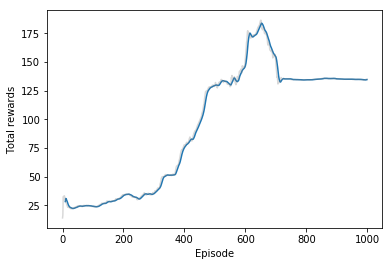

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

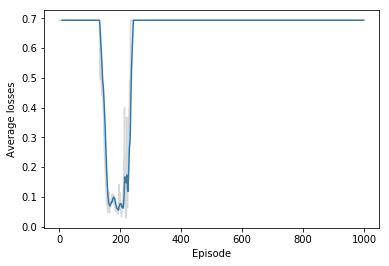

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.